# ECAL PhiSym on NanoAOD with awkward+coffea

## Import all the tools
    - use EcalPhiSymSchema to load the data into the proper classes

In [1]:
import awkward as ak
import numpy as np
from coffea.nanoevents import NanoEventsFactory
from ecalphisym import EcalPhiSymSchema

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc('font',**{'family':'sans-serif', 'sans-serif':['Helvetica'], 'size':'20'})
plt.rcParams['figure.figsize'] = '10,10'
plt.style.use('seaborn-white')

In [3]:
# replace with proper test file location
runs = NanoEventsFactory.from_root('../../pyphisym/data/Run2018D_test.root',
                                   schemaclass=EcalPhiSymSchema,
                                   treepath="/Runs").events()

## Group data by fill number
    - Prepare the grouping 
    - Perform the grouping using awkward.unflatten separately on each main collection

In [4]:
counts = np.unique(runs.EcalPhiSymInfo.fill, return_index=True)[1]
splits = np.diff(np.concatenate([counts, [len(runs.EcalPhiSymInfo.fill)]]))

In [5]:
info = ak.unflatten(runs.EcalPhiSymInfo, splits, axis=0, behavior=runs.behavior).sum(axis=1)
ebhits = ak.unflatten(runs.EcalPhiSymEB, splits, axis=0, behavior=runs.behavior).sum(axis=1)
eehits = ak.unflatten(runs.EcalPhiSymEE, splits, axis=0, behavior=runs.behavior).sum(axis=1)

## Compute k-factors
    - keep same definition as in Run2: the miscalibration values are centered
    at 0.

In [8]:
k = ak.linear_fit(info.miscalibs_eb, ebhits.sumet_v, axis=2)

/home/pigo/.conda/envs/phisym/lib/python3.10/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: divide by zero encountered in true_divide
  result = getattr(ufunc, method)(
/home/pigo/.conda/envs/phisym/lib/python3.10/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in true_divide
  result = getattr(ufunc, method)(


# K-factors plots examples
    - all k-factors (slopes from the fits)
    - all intercepts
    - 1 channel k-factor history
    - 1 iov k-factors map

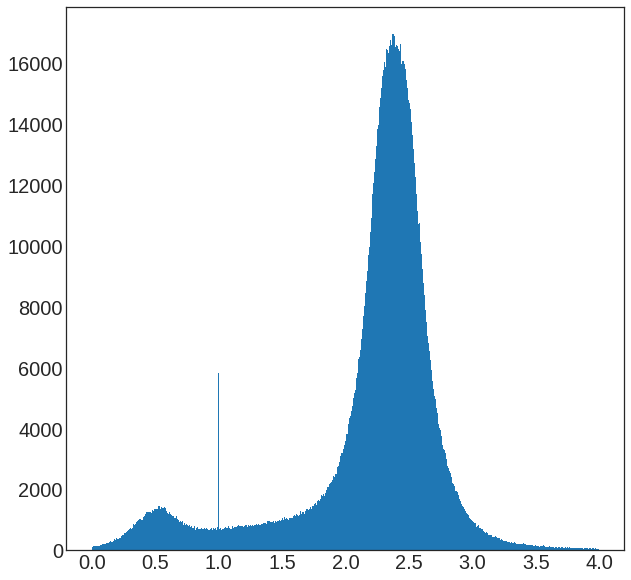

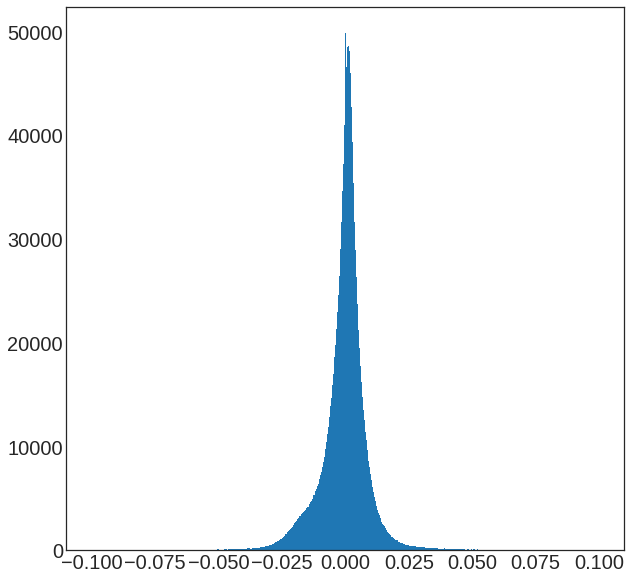

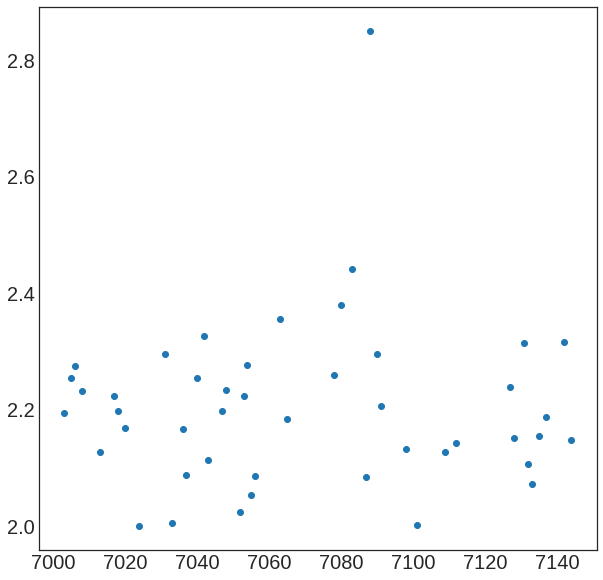

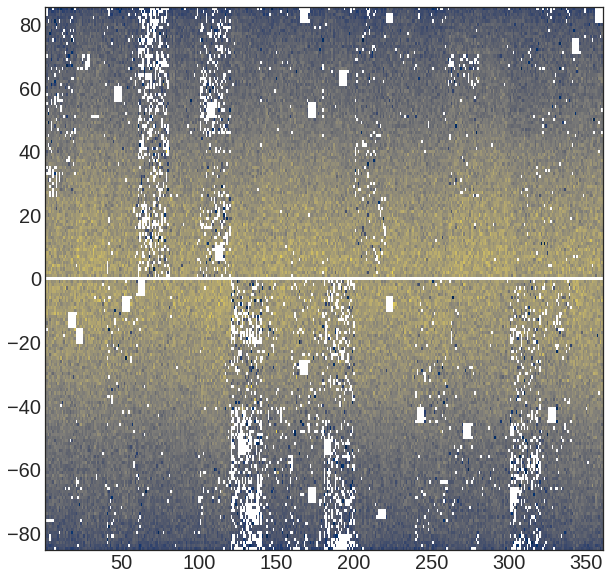

In [42]:
plt.hist(ak.flatten(k.slope), bins=1000, range=[0,4])
plt.show()
plt.hist(ak.flatten(k.intercept), bins=1000, range=[-0.1, 0.1])
plt.show()
plt.scatter(info.fill, k.slope[:,100])
plt.show()
plt.hist2d(ak.to_numpy(ebhits.iphi[1,:]), ak.to_numpy(ebhits.ieta[1,:]), weights=ak.to_numpy(k.slope[1]), 
           bins=[360, 171], range=[[0.5,360.5], [-85.5, 85.5]], 
           cmap='cividis', cmin=2, cmax=3)
plt.show()

## Compute EFlow
    - remove boundary channels (SM and module boundaries) from the total EB sum
    - Note: double check this definition with the Run2 one
    - Note: there was an issue with the first fill in the test file used for this example, hence the analysis starts from iov 1

In [6]:
def boundaryCrystals(data):
    """
    Flag crystals on module boundaries:
    - first and last crystals in a SM along phi (iphi % 20 == 0|1)
    - first and last crystals in a module along eta (|ieta| = 1, 25,26, 45,46, 65,66, 85)
    """

    bounds = ak.zeros_like(data.ieta)
    for idx in [1, 25, 25, 45, 46, 65, 66, 85]:
        bounds = bounds + (abs(data.ieta) == idx)
        
    return (data.iphi % 20 == 0) | (data.iphi % 20 == 1) | (bounds > 0)

In [46]:
sumEtEB = ak.sum(ak.mask(ebhits.sumet, boundaryCrystals(ebhits), valid_when=False), axis=1)

In [97]:
norm = ak.Array(np.repeat([ebhits.sumet[1]/sumEtEB[1]], 47, axis=0))
eflow = (((ebhits.sumet/sumEtEB)/norm)-1)/k.slope+1

## EFlow plots examples

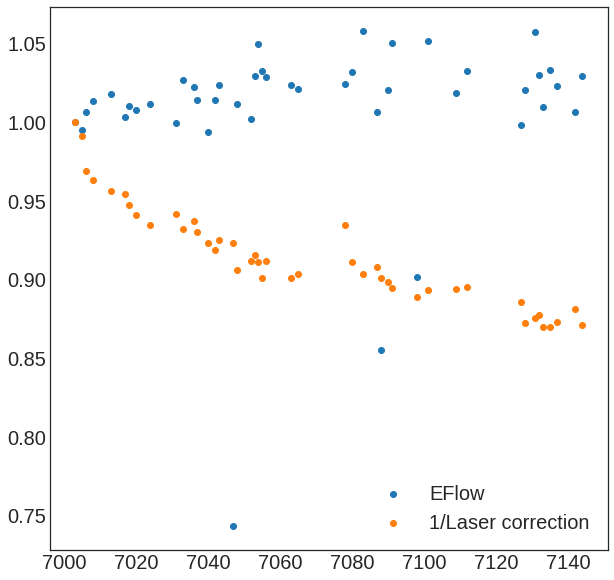

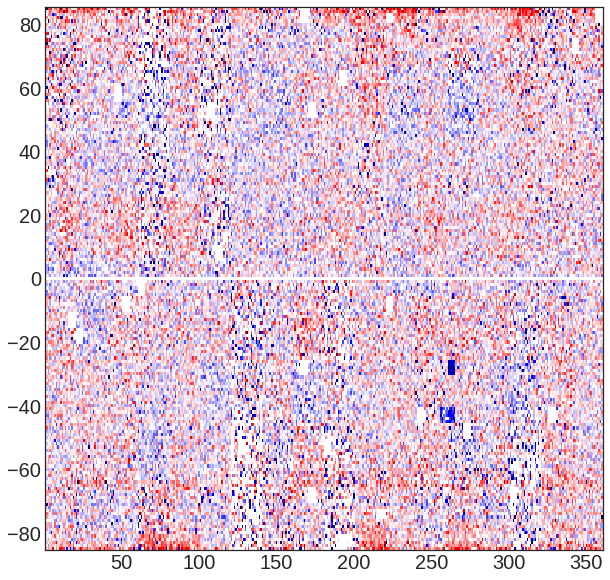

In [118]:
plt.scatter(info.fill[1:], eflow[1:,200], label='EFlow')
plt.scatter(info.fill[1:], (ebhits.sumlc[1,200]/ebhits.nhits[1,200])/(ebhits.sumlc[1:,200]/ebhits.nhits[1:,200]), 
            label='1/Laser correction')
plt.legend()
plt.show()
# plot the map of the last iov
plt.hist2d(ak.to_numpy(ebhits.iphi[-1,:]), ak.to_numpy(ebhits.ieta[-1,:]), weights=ak.to_numpy(eflow[-1]), 
           bins=[360, 171], range=[[0.5,360.5], [-85.5, 85.5]], 
           cmap='seismic', cmin=0.9, cmax=1.1)
plt.show()